In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [100]:
def gradient(f, i,j,k, ngrid):
    """
    Calculates the gradient between the nearest neighbors. 
    F=0 outside of the region.
    
    Parameters
    ----------
    f : np.ndarray
       Initial field grid.
    i,j,k : np.array
       i,j,k cells that the fluctuation was added to.
    """
    df = np.zeros(3)
    
    for x in range(len(df)):
        df[x] = f[i,j,k,x] + 0.0
    
        if i < (f.shape[0]-1): df[x] -= f[i+1,j,k,x]/6.0
        if i >= 0: df[x] -= f[i-1,j,k,x]/6.0
        
        if j < (f.shape[0]-1): df[x] -= f[i,j+1,k,x]/6.0
        if j >= 0: df[x] -= f[i,j-1,k,x]/6.0
            
        if k < (f.shape[0]-1): df[x] -= f[i,j,k+1,x]/6.0
        if k >= 0: df[x] -= f[i,j,k-1,x]/6.0
    
    dfm = np.sqrt(np.nansum(df**2))
    return dfm, df

In [180]:
def distance(f, i,j,k, fcrit, df, dfm):
    """
    Redistributes the cell where the avalanche occurred to neighboring 
    cells within the grid (does not go across boundaries).
    
    Parameters
    ----------
    f : np.ndarray
       Initial field grid.
    i,j,k : np.array
       i,j,k cells that the fluctuation was added to.
    fcrit : float
       The maximum value of E to trigger an event. 
    dfm : float
       The RMS of the delta f (df) array.
       
    Return
    ------
    f : np.ndarray
       Field grid now accounting for avalanche effects in neighboring cells.
    """
    con = fcrit / dfm
    
    for x in range(3):
        f[i,j,k,x] -= ((6.0/7.0) * df[x] * con)
        add = (1.0/7.0) * df[x] * con
        
        if i+1 < f.shape[0]-1:
            f[i+1,j,k,x] += add
        if i-1 > 0:
            f[i-1,j,k,x] += add
        
        if j+1 < f.shape[1]-1:
            f[i,j+1,k,x] += add
        if j-1 > 0:
            f[i,j-1,k,x] += add
            
        if k+1 < f.shape[2]-1:
            f[i,j,k+1,x] += add
        if k-1 > 0:
            f[i,j,k-1,x] += add
            
    return f

In [192]:
def flag_neighbors(arr, loc, ngrid, offset=1, nt=0):
    """
    Flags cells where perturbation was added along with neighboring cells 
    that are within the boundary of the grid
    
    Parameters
    ----------
    arr : np.ndarray 
       A counter array.
    loc : np.array
       i,j,k cells that the fluctuation was added to.
    ngrid : int
       The x,y,z dimension of the initial field (assumes cube).
    offset : int, optional
       The number of cells away from the perturbation to adjust. 
       Default = 1.
    nt : int, optional
       Counter to keep track of number of cells that need to be
       tested. Default = 0.
       
    Returns
    -------
    arr : np.ndarray
       Counter array now populated with locations.
    nt : int
       Counter that keeps track of number of cells that need to be tested.
    """
    lower, upper = np.array(loc,dtype=int)-offset, np.array(loc,dtype=int)+offset
    
    for x in range(3):
        arr[0,x] = loc[x]
            
    if upper[0]<ngrid:
        nt+=1
        arr[nt,0] = upper[0]
        arr[nt,1] = loc[1]
        arr[nt,2] = loc[2]
    
    if lower[0]>=0:
        nt+=1
        arr[nt,0] = lower[0]
        arr[nt,1] = loc[1]
        arr[nt,2] = loc[2]
        
    if upper[1]<ngrid:
        nt+=1
        arr[nt,0] = loc[0]
        arr[nt,1] = upper[1]
        arr[nt,2] = loc[2]
        
    if lower[1]>=0:
        nt+=1
        arr[nt,0] = loc[0]
        arr[nt,1] = lower[1]
        arr[nt,2] = loc[2]
        
    if upper[2]<ngrid:
        nt+=1
        arr[nt,0] = loc[0]
        arr[nt,1] = loc[1]
        arr[nt,2] = upper[2]
        
    if lower[2]>=0:
        nt+=1
        arr[nt,0] = loc[0]
        arr[nt,1] = loc[1]
        arr[nt,2] = lower[2]
        
    return arr, nt

In [193]:
def flag_secondary_neighbors(arr, loc, ngrid,nt):
    """
    Flags cells where perturbation was added along with neighboring cells 
    that are within the boundary of the grid
    
    Parameters
    ----------
    arr : np.ndarray 
       A counter array.
    loc : np.array
       i,j,k cells that the fluctuation was added to.
    ngrid : int
       The x,y,z dimension of the initial field (assumes cube).
       
    Returns
    -------
    arr : np.ndarray
       Counter array now populated with locations.
    nt : int
       Counter that keeps track of number of cells that need to be tested.
    """
    ni = np.arange(-1,2,1,dtype=int)+loc[0]
    ni = ni[(ni>=0) & (ni<ngrid)]
    
    nj = np.arange(-1,2,1,dtype=int)+loc[1]
    nj = nj[(nj>=0) & (nj<ngrid)]
    
    nk = np.arange(-1,2,1,dtype=int)+loc[2]
    nk = nk[(nk>=0) & (nk<ngrid)]
    
    # I believe this checks all of the combinations Marco wrote out...
    for x in ni:
        for y in nj:
            for z in nk:
                nt += 1
                arr[nt,0]=x
                arr[nt,1]=y
                arr[nt,2]=z
        
    return arr, nt

In [221]:
def run_loop(f, nfluc, fcrit, nfl1, nfl2, seed):
    """
    Adds fluctuations to the initial field.
    
    Parameters
    ----------
    f : np.ndarray
       Initial field array.
    nfluc : int
       Number of fluctuations to add.
    fcrit : float
       The maximum value of E to trigger an event. 
    seed : int
       Random seed to make results reproducible. 
    
    Returns
    -------
    nbine : np.array
       Array of the output energies.
    nbint : np.array
       Array of the output durations.
    nbinp : np.array
       Array of the output power (?).
    """
    nbine = np.zeros(f.shape[0]*f.shape[1]*f.shape[2])
    nbint = np.zeros(f.shape[0]*f.shape[1]*f.shape[2])
    nbinp = np.zeros(f.shape[0]*f.shape[1]*f.shape[2])
    
    np.random.seed(seed)
    
    for n in range(nfluc):
        mev = 0 # count the number of events during avalanche to determine size E
        nts = 0 # count number of steps in avalanche to determine duration T
        npk = 0 # keep track of the peak number of unstable cells during 
                    # the cascade to determine P
        
        # pick a random cell
        loc = np.random.randint(0,f.shape[0]-1,3)
        
        # add perturbation between -0.03 and +0.1
        pert = np.random.uniform(-0.03,0.1,3)
        for x in range(3):
            f[loc[0], loc[1], loc[2], x] += (pert[x]*fcrit)
        
        nfl1, nt = flag_neighbors(nfl1, loc, f.shape[0])
        # this part can definitely be sped up, but I'm going to rewrite it
        # the way marco did first
        
        ninst = 0 # reset count number for unstable cells in time step, ta
        for x in range(nt):
            dfm, df = gradient(f, nfl1[x,0], nfl1[x,1], nfl1[x,2], f.shape[0])
            if dfm > fcrit:
                print('AVALANCHE')
                ninst += 1
                mev   += 1
                
                f = distance(f,nfl1[x,0], nfl1[x,1], nfl1[x,2], fcrit, df, dfm)
                nfl2, nt2 = flag_neighbors(nfl2, 
                                           [nfl1[x,0], nfl1[x,1], nfl1[x,2]], 
                                           f.shape[0])
                nfl2, nt2 = flag_neighbors(nfl2, 
                                           [nfl1[x,0], nfl1[x,1], nfl1[x,2]], 
                                           f.shape[0], offset=2, nt=nt2)
                nfl2, nt2 = flag_secondary_neighbors(nfl2,
                                                     [nfl1[x,0], nfl1[x,1], nfl1[x,2]], 
                                                     f.shape[0], nt2)
        
        # if any cells are unstable, update t_a, pass nfl2, take next step in avalanche
        if ninst > 0:
            npk = np.nanmax([ninst,npk])
            nts += 1
            nfl1[:nt2,0] = nfl2[:nt2,0]
            nfl1[:nt2,1] = nfl2[:nt2,1]
            nfl1[:nt2,2] = nfl2[:nt2,2]
        
        
        # bin data for nloop
        if mev >= 0:
            nbine[mev] += 1
            nbint[nts] += 1
            nbinp[npk] += 1
        
    return nbine, nbint, nbinp, nfl1

In [228]:
def __init__(ngrid, nloops, nfluc, fcrit, seed):
    """
    The function to run all functions.
    
    Parameters
    ----------
    ngrid : int
       The number of cells for each grid dimension.
    nloops : int
       The number of loops to run over.
    nfluc : int
       The number of fluctuations added per loop.
    fcrit : float
       The maximum value of E to trigger an event.
    seed : int
       Random seed to initialize the runs.
    """
    f = np.zeros((ngrid,ngrid,ngrid,3)) # Sets the initial field configuration
    f[:,:,:,1] = fcrit
    
    nfl1 = np.zeros((150000,3),dtype=int) # Sets an initial counter
    nfl2 = np.zeros((150000,3),dtype=int) # Sets a second counter
    
    for i in range(nloops):
        e, t, p, nf = run_loop(f, nfluc, fcrit, nfl1, nfl2, seed)
        plt.plot(e,'.')
        
        print("Done with loop = {}".format(i))

AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
Done with loop = 0
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
AVALANCHE
A

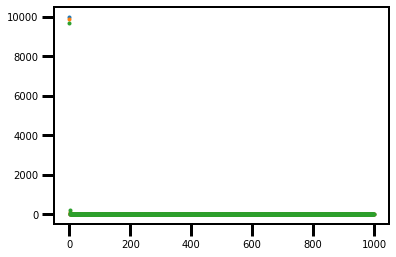

In [229]:
__init__(10,3,10000,7.0,122)